# Section 4: Challenges and Future Directions

TODO lists:

* In the illustration figure of long-tail samples, remove FR; (done)

* Add the disparate impacts illustration figure from our fairness paper (Figure 2 in paper) (done)

## Detect long-tail (rare) samples in a dataset

### Q1: What are long-tail samples?

A figure below illustrates what are high-frequency features and long-tailed features. 

Long-tailed features appear to have a low-frequency in the data and tend to be under-fitted by the deep neural nets. Hence, bad performed.

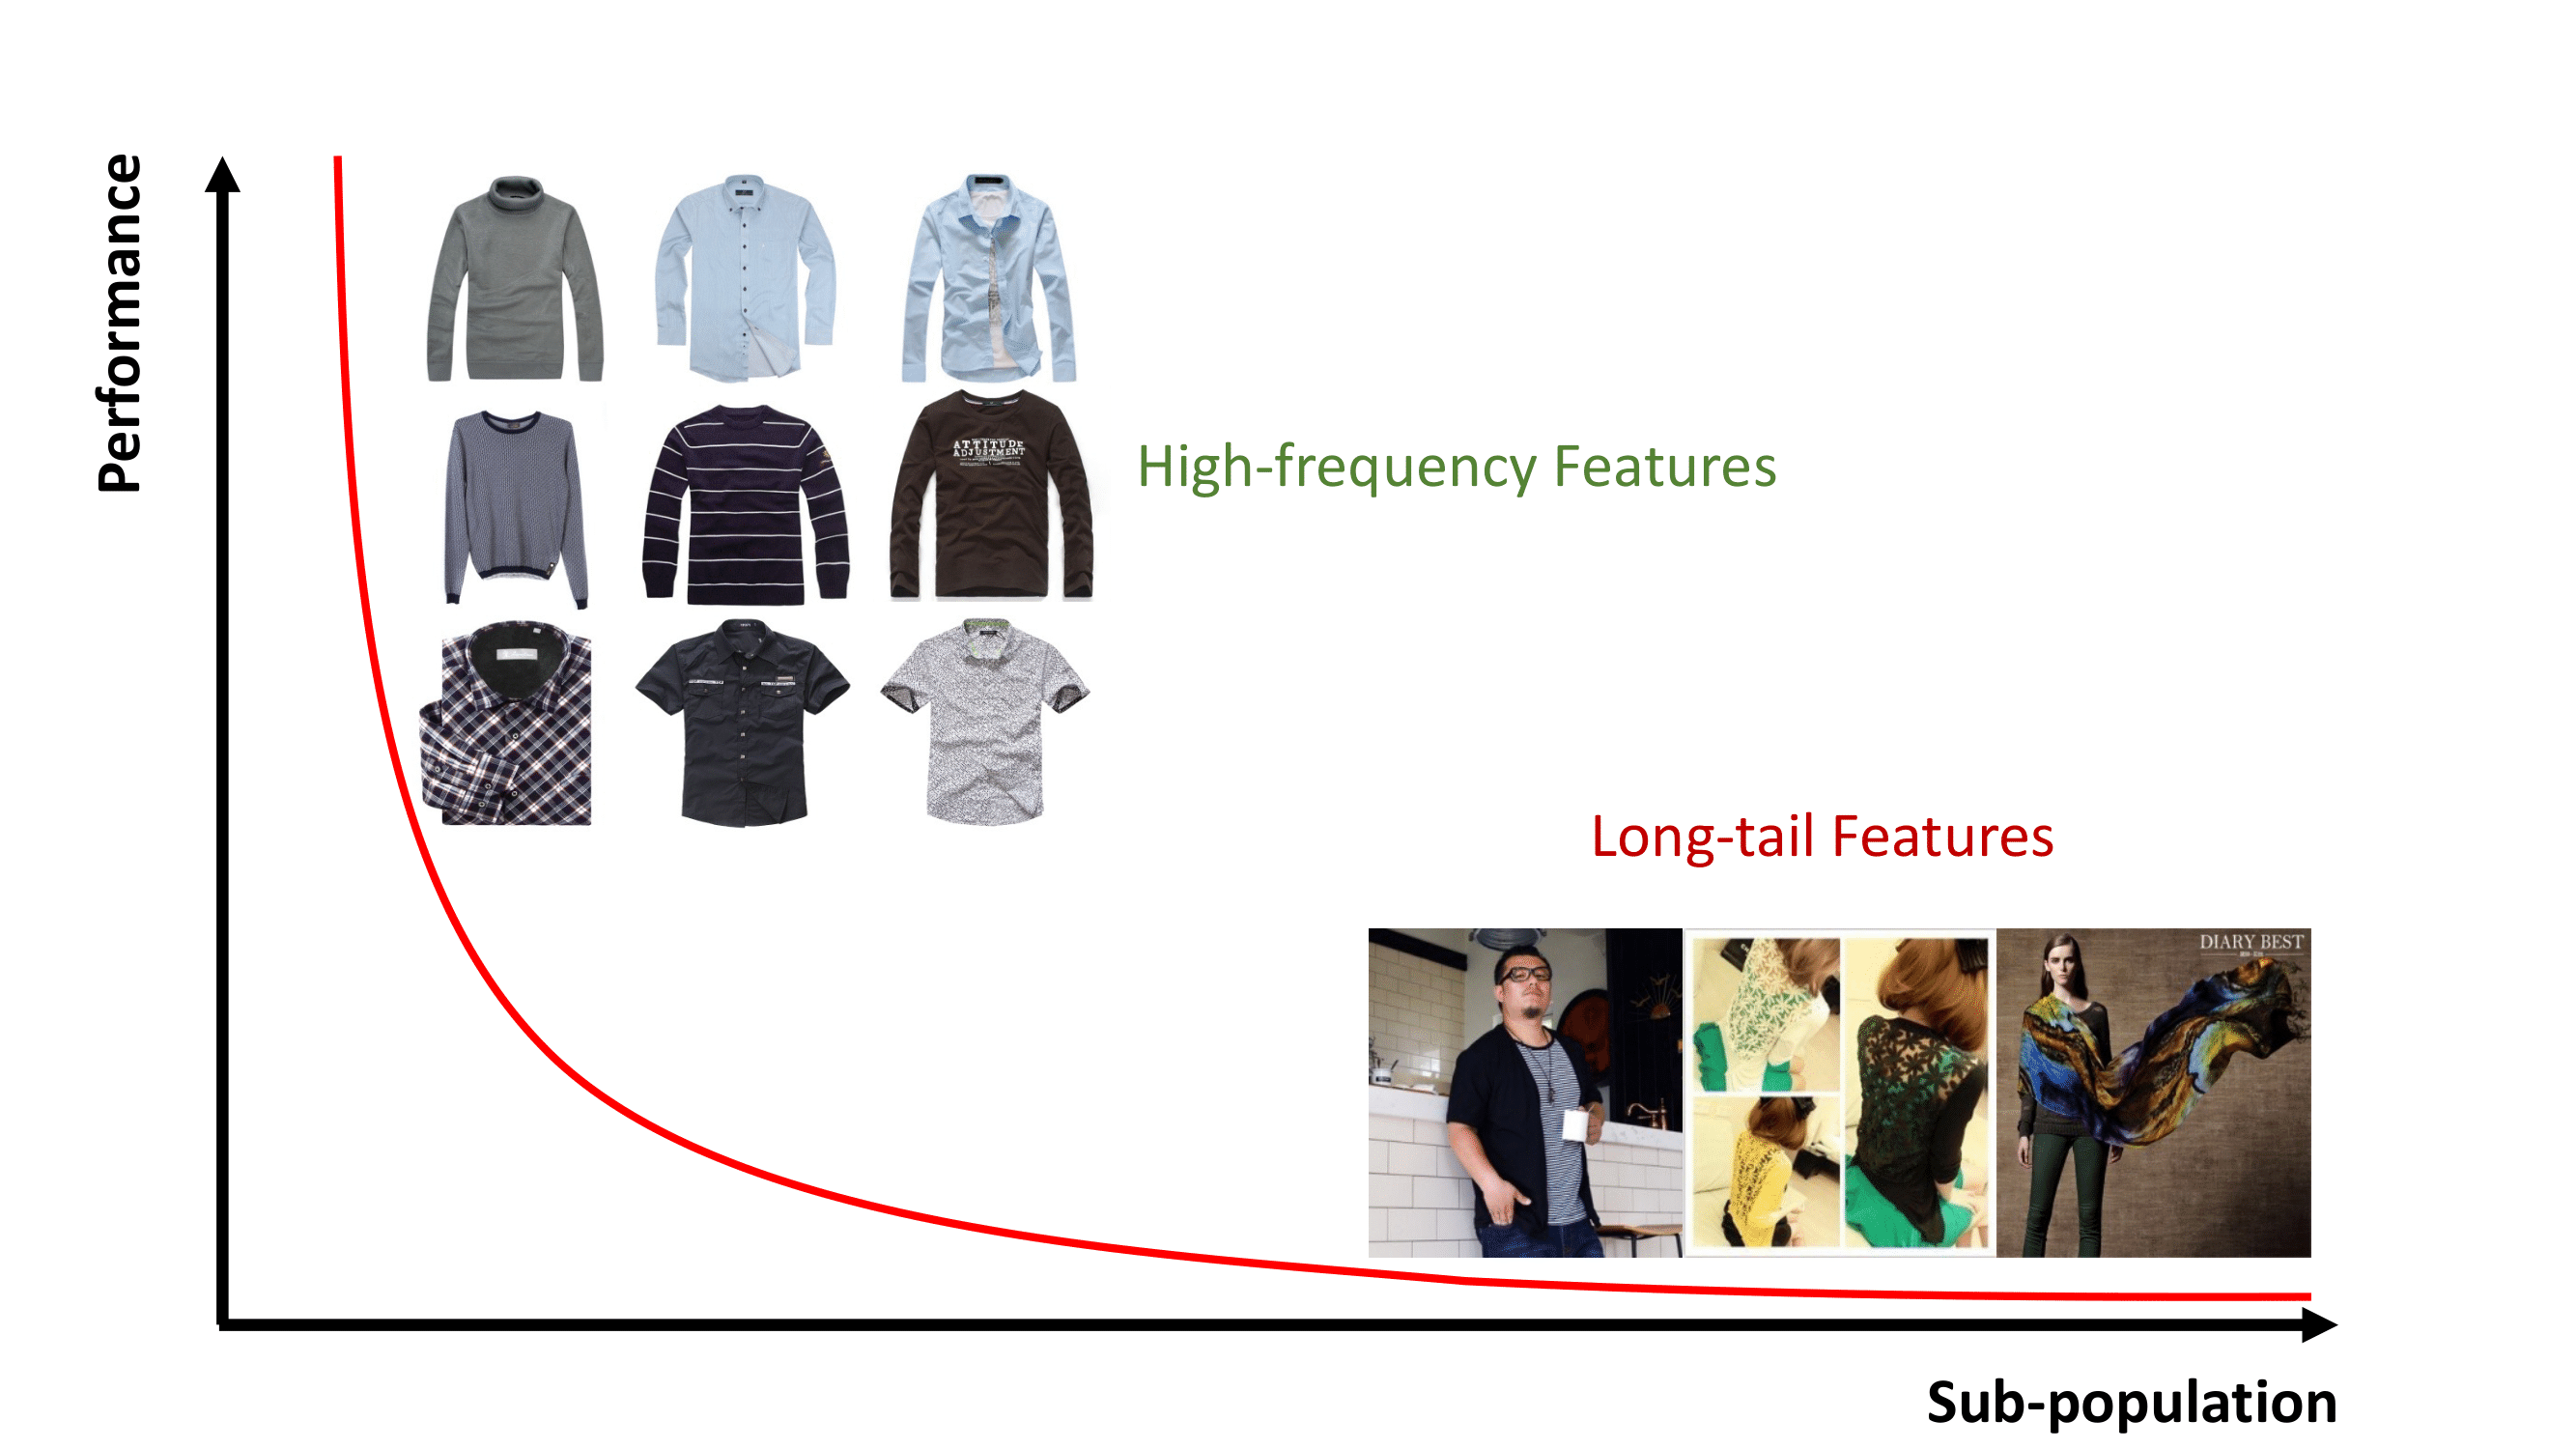

In [1]:
import sys
import os
from IPython.display import Image
path = 'tutorial_imgs/long-tail-sample.png'
display(Image(filename = path, width = 400, height = 200))

### Challenge 1: Detecting Long-tail samples

**Solution: Use embeddings to detect long-tail samples (CIFAR-10)**

**Basic intuition**: 

Consider the averaged distance between each sample and its $k$ nearest neighbors;

**Long-tail samples**: 

A sample with a larger distance by referring to its neighbors (embedding perspective) is likely to be a long-tail/rare sample.


**Pros**: 

* General: works for any data that could be extraced as embeddings! 

* Fast: get embeddings and produce long-tail scores fast!

* Insight: embeddings are key and poopular components for depicting data samples!

In [2]:
os.chdir('./docta')
# o_path = os.getcwd()
# sys.path.append(o_path) # set path so that modules from other foloders can be loaded
# print(o_path)

**Step 1** get long-tailed scores with pre-defined configs.

In [3]:
%run ./tools/docta_rare_pattern.py --feature_type 'embedding'

==== Docta: Doctor for your data. Current version: 0.1 ====
Files already downloaded and verified
==== Docta: Doctor for your data. Current version: 0.1 ====
Files already downloaded and verified


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 129, in _main
    prepare(preparation_data)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 240, in prepare
    _fixup_main_from_path(data['init_main_from_path'])
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 291, in _fixup_main_from_path
    main_content = runpy.run_path(main_path,
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen runpy>", line 291, in run_path
  File "<frozen runpy>", line 98, in _run_module_code
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/d

KeyboardInterrupt: 

**Step2** Take a look at the long-tail scores and samples

In [ ]:
import pandas as pd
lt_score_embedd = pd.read_csv('./results/CIFAR_c10/embedding.csv')
lt_score_embedd.head()

In [ ]:
# A help function for visualization
# %matplotlib notebook
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
def visualize_lt(idxs, data, labels, label_name):
    plt.rcParams["figure.figsize"] = (10,8)
    size = len(idxs)
    width = int(size / 5)
    for i in range(size):
        ax = plt.subplot(width,5,i+1)
        idx = idxs[i]
        ax.imshow(data.feature[idx])
        ax.set_title(f"{label_name[labels[idx]]}")
        ax.axis('off')
    plt.show()

### Visualization of long-tail images (top 20 among 50K)

In [ ]:

dataset = Cifar10_clean(cfg, train=True)
clean_label = dataset.label
feature = dataset.feature 
label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_show = 20 # show 20 pics
lt_score = lt_score_embedd['longtail_scores'].tolist()
topN = sorted(range(len(lt_score)), key = lambda sub: lt_score[sub])[-num_show:]
visualize_lt(idxs=topN, data=dataset, labels=clean_label, label_name=label_name)

In [ ]:
print(f"Indexes of {len(topN)} samples with highest long-tail scores are {topN}")

### Visualization of head images (top 20 among 50K)

In [ ]:
lastN = sorted(range(len(lt_score)), key = lambda sub: lt_score[sub])[:num_show]
visualize_lt(idxs=lastN, data=dataset, labels=clean_label, label_name=label_name)

In [ ]:
print(f"Indexes of {len(lastN)} samples with lowest long-tail scores are {lastN}")

### The distribution of the per-sample long-tail scores 

In [ ]:
lt_score_embedd['longtail_scores'].hist(bins=100, figsize=[6,4])

### Challenge 2: Learning with Noisily Labeled Long-tailed Samples

Biased and noisy training datasets are prevalent and impose challenges for learning. The biases and noise can happen both at the sampling and label collection stages: 

* A dataset often contains numerous sub-populations and the size of these sub-populations tends to be long-tailed distributed, where the tail sub-populations have an exponentially scaled probability of being under-sampled. 

* A dataset tends to suffer from noisy labels if collected from unverified sources.

The figure below illustrates the disparate impacts of sub-populations with a real-world long-tailed noisy CIFAR-20 dataset (CIFAR-20N) when using existing learning with noisy labels methods. 

<table>
  <tr>
    <td ><img src="tutorial_imgs/dispare-impacts.png" width="1100"> 

    Figure: How each method improves per sub-population (100 classes) test accuracy w.r.t. CE loss on CIFAR-20 dataset. 
  
</td>
  </tr>
</table> 

For each sub-figure, the $x$-axis indicates the CE accuracy. $y$-axis denotes the performance of robust/long-tailed approaches. 
    
Each dot denotes the test accuracy pair $(\text{Acc}_{\text{CE}}, \text{Acc}_{\text{Method}})$ for each sub-population. The line $y=x$ stands for the case that CE performs the same as the robust treatment on a particular sub-population.

The <font color='blue'> blue </font> (<font color='red'>red</font>) dot <font color='blue'> above </font> (<font color='red'>below</font>) the line shows the robust treatment has<font color='blue'> positive </font>(<font color='red'>negative</font>) effect on this sub-population compared with CE. In the sub-titles, "Balance" denotes the balanced training data (w.r.t. clean labels); "Imbalance" means the training dataset follows a long-tailed distribution where the ratio between max and min number of samples in the sub-populations is 100; "Clean": the labels of training samples are clean; "Noisy": 25.6\% correct labels are wrongly labeled by the human annotators.The test dataset is clean and balanced.

**Experiment design:**

* We adopt the CIFAR-20 dataset (20 coarse classes in CIFAR-100). Each coarse class includes 5 different sub-populations (fine classes in CIFAR-100).

* We train a Resnet-32 for a 20-class classification task. Note that we have access to the sub-population information in the test time evaluation (20*5 sub-populations), for per-class (20 classes) accuracy, we further split it into the 5 sub-population accuracy. For example, given images that belong to the coarse class (trees), we will monitor the corresponding 5 sub-populations (maple, oak, palm, pine, willow) to see how many of the images are correctly classified as the class “trees”. For the sub-plots,

* For sub-plots with “Noisy” included in the sub-caption, it indicates that the noisy label was obtained from the CIFAR-20N dataset, which contains roughly 25.6% of wrong labels.